# **Carga de datos**

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,755 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,077 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,062 kB in 9s (330 kB/s)
Reading package lists... Done
Build

## Importación de las librerías

In [ ]:
import pyspark
import pyspark.sql.functions as F
import numpy as np
from pyspark.sql import SparkSession
import numpy as np
from datetime import datetime, timedelta
from pyspark.sql.window import Window
import numpy as np
import math
import pandas as pd
import subprocess
from google.colab import drive
import plotly.express as px
import numpy as np
import pandas as pd
from pyspark.sql.functions import mean


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

### Creación del SparkContext

In [ ]:
appName = "sprint4_abd14"

In [ ]:
spark = SparkSession.builder\
                    .appName(appName) \
                    .getOrCreate()
sc = spark.sparkContext

In [ ]:
spark = SparkSession.builder.master("yarn") \
                    .appName(appName) \
                    .getOrCreate()
sc = spark.sparkContext
table = spark.table("technology_information.data_orc")

### Extracción de los datos

In [ ]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

y1 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('data_year_1.csv')
y2 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('data_year_2.csv')
y3 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('data_year_3.csv')
y4 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('data_year_4.csv')
y5 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('data_year_5.csv')
y6 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('data_year_6.csv')
df = y1.union(y2).union(y3).union(y4).union(y5).union(y6)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Quitar columnas que no vamos a utilizar

In [ ]:
table = y1.union(y2).union(y3).union(y4).union(y5).union(y6)
table1 = table.filter(F.col("symbol")=="IBM")
table1 = table1.withColumn("index", F.monotonically_increasing_id() + 1).drop("date").drop("cik").drop("stocksplits").drop("dividends")

+----+------+------------------+-----------------+------------------+------------------+---------+------------+-----+
| _c0|Symbol|              Open|             High|               Low|             Close|   Volume|Stock Splits|index|
+----+------+------------------+-----------------+------------------+------------------+---------+------------+-----+
|6778|   IBM|112.76093494266284|114.5311089264952|112.03709157817772| 113.5851058959961|9875914.0|         0.0|    2|
|6779|   IBM|114.41642523569091|116.3299355817973|114.21575864074724|115.88560485839844|7903785.0|         0.0|    3|
+----+------+------------------+-----------------+------------------+------------------+---------+------------+-----+
only showing top 2 rows



### Creamos las columnas de lag

In [ ]:
window_spec = Window.partitionBy('symbol').orderBy('index')
for column in ['Open', 'Close', 'High', 'Low', 'Volume']:
    table1 = table1.withColumn(f'prev_{column}', F.lag(table1[column], 1).over(window_spec))

### Dropeamos la primera fila

In [ ]:
table1 = table1.filter(F.col("index")>1)

### Rellenamos NAN con la media de cada columna

In [ ]:
def fillna_mean(df, include=set()):
    means = df.agg(*(
        mean(x).alias(x) for x in df.columns if x in include
    ))
    return df.fillna(means.first().asDict())

df = fillna_mean(df, ['Open', 'High', 'Low', 'Close', 'Volume'])

### Creamos el vector para el entrenamiento

In [ ]:
feature_columns = ['prev_Open', 'prev_Close', 'prev_High', 'prev_Low', 'prev_Volume']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)
df = df.select("features", "close")

### Dividimos en train y test

In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

### Definimos el modelo

In [ ]:
rf = RandomForestRegressor(labelCol="close", featuresCol="features")
rf_tr = rf.fit(train_data)

### Predecimos

In [ ]:
predictions = rf_tr.transform(test_data)

### Evaluamos

In [ ]:
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R2 on test data = {r2}")

R2 on test data = 0.9789384162380641


### Pintamos los resultados

In [ ]:
predictions_pandas = predictions.select("close", "prediction").toPandas()

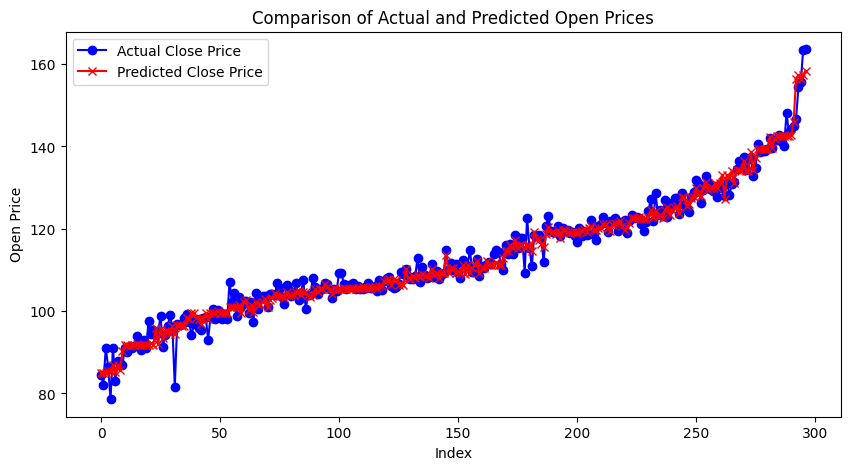

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(predictions_pandas['close'], label='Actual Close Price', color='blue', marker='o')
plt.plot(predictions_pandas['prediction'], label='Predicted Close Price', color='red', marker='x')
plt.title('Comparison of Actual and Predicted Open Prices')
plt.xlabel('Index')
plt.ylabel('Open Price')
plt.legend()
plt.show()